# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Homework 8: Reinforcement Learning [100 pts]


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>

**DISCLAIMER**: No public reproduction of this homework nor its solution is allowed without the explicit consent of their authors.



<hr style="height:2pt">

---

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit.
- Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
# Numpy and plotting libraries

import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

# Overview

The objective of this homework assignment is to get a taste of implementing a planning algorithm in a very simple setting. 

<div class='exercise'><b>  Markov Decision Process [100 points] </b></div>


We have a hallway consisting of 5 blocks (states 0-4). There are two actions, which deterministically move the agent to the left or the right. More explicitly: Performing action “left” in state 0 keeps you in state 0, moves you from state 1 to state 0, from state 2 to state 1, state 3 to state 2, and state 4 to state 3. Performing action “right” in state 4 keeps you in state 4, moves you from state 3 to state 4, from state 2 to state 3, from state 1 to state 2, and from state 0 to state 1. The agent receives a reward of -1.0 if it starts any iteration in state 0, state 1, state 2, or state 3. The agent receives a reward of +10.0 if it starts in state 4. Let the discount factor γ = 0.75.

We provide class MDP that instantiates an object representing a Markov decision process and verifies shapes.

**1.1** MDP proble [10 pts]: Build an MDP representing the hallway setting described above, by completing the function `build_hallway_mdp()`. You need to specify the array T that encodes the transitions from state and actions into next states; and a reward vector R that specifies the reward for being at a certain state.

**1.2**  Policy Evaluation [20 pts]: Initialize a policy “left” for every state (a 1D numpy array). Implement policy evaluation as described in lecture (also in Chapter 4 of [Sutton and Barto](http://incompleteideas.net/book/RLbook2018.pdf)). That is, for each possible starting state, what is the expected sum of future rewards for this policy? Using an iterative approach, how many iterations did it take for the value of the policy to converge to a precision of 10−5? 

**1.3**  Q-function Computation [20 pts]: Compute the Q-function for the `always_left` policy above. Do you see any opportunties for policy improvement?

**1.4** Policy Iteration [20 pts]: Using your solutions to questions 1.2 and 1.3 above, implement policy iteration. Report the sequence of policies you find starting with the policy “left” in every state. How many rounds of policy iteration are required to converge to the optimal policy? 

**1.5** [10 pts] What are the effects of different choices of the discount factor on the convergence of policy evaluation? Run policy evaluation for discount factor $\gamma \in [ 10^{-12}, 10^{-3}, 0.1, 0.33, 0.67, 0.9, 0.95, 0.99]$.

**1.6** [20 pts] What happens if the transitions are stochastic? Recode the MDP with probability of switching to the opposite action of 0.1. What are now the values when following the optimal policy?

In [3]:
class MDP(object):
    """Wrapper for a discrete Markov decision process that makes shape checks"""
    
    def __init__(self, T, R, discount):
        """Initialize the Markov Decision Process.
        - `T` should be a 3D array whose dimensions represent initial states,
          actions, and next states, respectively, and whose values represent
          transition probabilities.
        - `R` should be a 1D array describing rewards for beginning each
          timestep in a particular state (or a 3D array like `T`). It will be
          transformed into the appropriate 3D shape.
        - `discount` should be a value in [0,1) controlling the decay of future
          rewards."""
        Ds, Da, _ = T.shape
        if T.shape not in [(Ds, Da, Ds)]:
            raise ValueError("T should be in R^|S|x|A|x|S|")
        if R.shape not in [(Ds, Da, Ds), (Ds,)]:
            raise ValueError("R should be in R^|S| or like T")
        if discount < 0 or discount >= 1:
            raise ValueError("discount should be in [0,1)")
        if R.shape == (Ds,):  # Expand R if necessary
            R = np.array([[[R[s1] for s2 in range(Ds)] for a in range(Da)] for s1 in range(Ds)])
        self.T = T
        self.R = R
        self.discount = discount
        self.num_states = Ds
        self.num_actions = Da
        self.states = np.arange(Ds)
        self.actions = np.arange(Da)

**1.1** MDP proble [10 pts]: Build an MDP representing the hallway setting described above, by completing the function `build_hallway_mdp()`. You need to specify the array T that encodes the transitions from state and actions into next states; and a reward vector R that specifies the reward for being at a certain state.


In [4]:
def build_hallway_mdp():
    """Build an MDP representing the hallway setting described."""
    # your code here
    
    T = np.zeros((5,2,5))
    
    epsilon = 0
    
    T = np.zeros((5,2,5))
    
    idx_i = np.array([0,0,1,1,2,2,3,3,4,4])
    idx_j = np.array([0,1]*5)
    idx_k = np.copy(idx_i)
    idx_k[1:-2:2] += 1
    idx_k[2::2] -= 1
    
    T[idx_i, idx_j, idx_k] = 1 - epsilon
    
    R = -np.ones(5)
    R[4] = 10
    
    # end of your code here
    return MDP(T, R, 0.75)

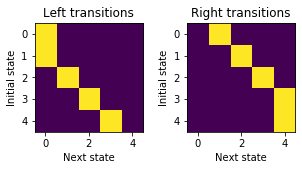

In [5]:
# Run for sanity check
mdp = build_hallway_mdp()

plt.figure(figsize=(5,2))
plt.subplot(121, title='Left transitions')
plt.imshow(mdp.T[:,0,:])
plt.ylabel("Initial state"); plt.xlabel('Next state')
plt.subplot(122, title='Right transitions')
plt.imshow(mdp.T[:,1,:])
plt.ylabel("Initial state"); plt.xlabel('Next state')
plt.show()

**1.2**  Policy Evaluation [20 pts]: Initialize a policy “left” for every state (a 1D numpy array). Implement policy evaluation as described in lecture (also in Chapter 4 of [Sutton and Barto](http://incompleteideas.net/book/RLbook2018.pdf)). That is, for each possible starting state, what is the expected sum of future rewards for this policy? Using an iterative approach, how many iterations did it take for the value of the policy to converge to a precision of 10−5?


In [6]:
def build_always_left_policy():
    """Build a policy representing the action "left" in every state."""
    # your code here
    
    policy = np.zeros(5, dtype=np.int)
    return policy

In [7]:
def iterative_value_estimation(mdp, policy, tol=1e-5):
    """Value estimation algorithm from page 75, Sutton and Barto. Returns an
    estimate of the value of a given policy under the MDP (with the number of
    iterations required to reach specified tolerance)."""
    V = np.zeros(mdp.num_states)
    num_iters = 0
       
    # your code here
    
    # Extract the states of MDP
    states = mdp.states
        
    # Compute the reward for current action as per policy
    current_action_value = (mdp.T * mdp.R).sum(axis=-1)[states, policy]
    
    # Compute the transition matrix
    T = mdp.T[states, policy,:]
    
    # Iterate while the difference (delta) is greater than threshold i.e. tol
    while True:
        delta = 0
            
        # For the given state and policy determine the next state
        V_next = np.dot(T, V)

        # For give state, action, and next state determine the value
        state_action_value = current_action_value + (V_next * mdp.discount)

        # Update the delta to check for loop breaking
        delta = max(delta, np.abs(state_action_value - V).max())

        # Update the value for the current state
        V = state_action_value 
        
        # Update the number of iterations
        num_iters += 1 
        
        # Check if threshold for breaking iteration is reached
        if delta < tol:
            break
    
    # end of your code here
    return V, num_iters

Policy value was:
[-4. -4. -4. -4.  7.]
Number of Iterations to Converge to a precision of 10−5:
42


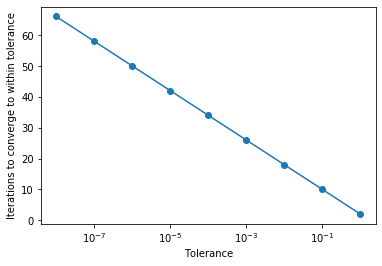

In [8]:
# Run for sanity check
always_left = build_always_left_policy()

values, iters = iterative_value_estimation(mdp, always_left)
print('Policy value was:')
print(values.round(4))

print('Number of Iterations to Converge to a precision of 10−5:')
print(iters)

tols = np.logspace(0,-8,9)
iters = [iterative_value_estimation(mdp, always_left, tol=tol)[1] for tol in tols]
plt.plot(tols, iters, marker='o')
plt.xscale('log')
plt.xlabel("Tolerance")
plt.ylabel("Iterations to converge to within tolerance")
plt.show()

<div style="border: 3px solid #800080; padding: 10px"> 

***Expected sum of future rewards for "Always Left" policy:***

State|Future Reward
-|-
0|-4
1|-4
2|-4
3|-4
4|7
<br>

***Number of iterations for the value of the policy to converge to a precision of 10−5:*** **`42`**

**1.3**  Q-function Computation [20 pts]: Compute the Q-function for the `always_left` policy above. Do you see any opportunties for policy improvement?


In [9]:
# 1.3
def Q_function(mdp, policy, tol=1e-5):
    """Q function from Equation 4.6, Sutton and Barto. For each state and
    action, returns the value of performing the action at that state, then
    following the policy thereafter."""
    # your code here
    
    # Initialize the Q arrays
    Q = np.sum((mdp.T * mdp.R), axis=2)
    
    # Generate the Value vector
    V, _ = iterative_value_estimation(mdp, policy, tol)
    
    # State Vector
    V_next = np.dot(mdp.T, V)
    
    Q += V_next * mdp.discount
    
    # end of your code here
    assert Q.shape == (mdp.num_states, mdp.num_actions)
    return Q

In [10]:
# Run for sanity check

Q = Q_function(mdp, always_left)
print('Q function was:')
print(Q.round(4))

Q function was:
[[-4.   -4.  ]
 [-4.   -4.  ]
 [-4.   -4.  ]
 [-4.    4.25]
 [ 7.   15.25]]


<div style="border: 3px solid #800080; padding: 10px"> 

***Opportunities for Policy Improvements:***
* For state 3 and 4:
    - We can increase Q-value by changing our first action to go right instead of go left
    - Q-value for starting in state 3 will increase from -4 to 4.25
    - Q-value for starting in state 4 will increase from 7 to 15.25
* **Just from above a better policy will be:**

Starting State | Action
---------------|-------
0              | Go Left
1              | Go Left
2              | Go Left
3              | Go Right
4              | Go Right

**1.4** Policy Iteration [20 pts]: Using your solutions to questions 1.2 and 1.3 above, implement policy iteration. Report the sequence of policies you find starting with the policy “left” in every state. How many rounds of policy iteration are required to converge to the optimal policy?


In [11]:
# 1.4
def policy_iteration(mdp, init_policy=None, tol=1e-5):
    """Policy iteration algorithm from page 80, Sutton and Barto.
    Iteratively transform the initial policy to become optimal.
    Return the full path."""
    # your code here
    
    # If no init_policy is specified, initialize the policy
    if init_policy is None:
        init_policy = np.zeros(mdp.num_states)
    
    # Add the initial policy to the list of policies
    policies = [init_policy]
    
    # Interate till policy stablizes
    while True:
        
        # Get the Q-values based on the current policy
        Q = Q_function(mdp, init_policy, tol)
        
        # Based on the current Q-values determine the best policy
        new_policy = Q.argmax(axis=1)
        
        # Check if threshold for breaking iteration is reached
        if (new_policy == init_policy).all():
            break
        
        # Add the new policy to the list of policies
        policies.append(new_policy)
        
        # Set the current policy equal to new policy
        init_policy = new_policy
    
    # end of your code here
    return policies

In [12]:
# Sanity check

policy_iters = policy_iteration(mdp, always_left)
policy_iters

[array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 1]),
 array([0, 0, 1, 1, 1]),
 array([0, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1])]

<div style="border: 3px solid #800080; padding: 10px"> 

***Optimal Policy:***

Starting State | Action
---------------|-------
0              | Go Right
1              | Go Right
2              | Go Right
3              | Go Right
4              | Go Right

***Number of Iterations to Converge to Optimal Policy:*** **`5`** *(counting the inital policy and not making the last duplicate update)*

***Note:*** The convergence actually happens in `4` algorithmic iterations but `5` unique different policies. **Since we do not perform update when the updated policy is same as initial policy, we do not count the last iteration).**

**1.5** [10 pts] What are the effects of different choices of the discount factor on the convergence of policy evaluation? Run policy evaluation for discount factor $\gamma \in [ 10^{-12}, 10^{-3}, 0.1, 0.33, 0.67, 0.9, 0.95, 0.99]$.


In [13]:
# 1.5
# your code here

discount_factors = [ 10**(-12), 10**(-3), 0.1, 0.33, 0.67, 0.9, 0.95, 0.99]

iters_by_factor = []

for gamma in discount_factors:
    mdp.discount = gamma
    _, num_iters = iterative_value_estimation(mdp, always_left)
    iters_by_factor.append(num_iters)

print("Iterations by Discount Factors = {}".format(iters_by_factor))

Iterations by Discount Factors = [2, 3, 7, 12, 30, 111, 226, 1147]


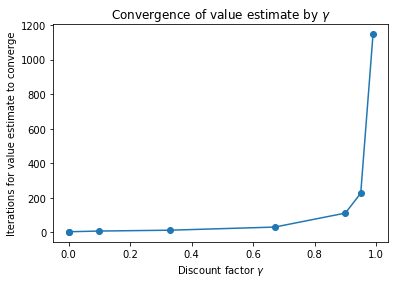

In [14]:
plt.plot(discount_factors, iters_by_factor, marker='o')
plt.xlabel('Discount factor $\gamma$')
plt.ylabel('Iterations for value estimate to converge')
plt.title("Convergence of value estimate by $\gamma$")
plt.show()

<div style="border: 3px solid #800080; padding: 10px"> 

Gamma|Iterations for Convergence
-----|--------------------------
1e-12|2
0.001|3
0.10 |7
0.33 |12
0.67 |30
0.90 |111
0.95 |226
0.99 |1147

***Effects of the discount factor on the convergence of policy:***
* For really small discount rates, the convergence happens quickly, i.e. it take only 2 itertations for convergence when discount rate is 1e-12 and 3 iterations when discount rate increases to 0.001
* Number of iterations needed for convergence increases exponetially with the increase in the discount rate
    - It will approach infinity as discount rate approaches 1
* For small discount rates the convergence happens faster as only initial steps add any meaningful term to the Value function.
    - Higher order terms  i.e. higher powers of discount rates tend to zero much faster for small discount rates than for large discount rates
* Once thing to note is that the absolute number of iterations required for convergence is also a function of the threshold (tol=1e-5)
    - Higher the threshold, faster the convergence and lower the threshold, slower the convergence

**1.6** [20 pts] What happens if the transitions are stochastic? Recode the MDP with probability of switching to the opposite action of 0.1. What are now the values when following the optimal policy?

In [15]:
# 1.6
# your code here

def build_stochastic_hallway_mdp():
    """Build an stochastic MDP representing the hallway setting described."""
    # your code here
    
    epsilon = 0.1
    
    T = np.zeros((5,2,5))
    
    idx_i = np.array([0,0,1,1,2,2,3,3,4,4])
    idx_j = np.array([0,1]*5)
    idx_k = np.copy(idx_i)
    idx_k[1:-2:2] += 1
    idx_k[2::2] -= 1
    
    T[idx_i, idx_j, idx_k] = 1 - epsilon
    
    idx_k = np.copy(idx_i)
    idx_k[3::2] -= 1
    idx_k[:-2:2] += 1
    
    T[idx_i, idx_j, idx_k] = epsilon
    
    R = -np.ones(5)
    R[4] = 10
    
    # end of your code here
    return MDP(T, R, 0.75)

In [16]:
# Get the optimal policy
mdp_stochastic = build_stochastic_hallway_mdp()
policy_iters = policy_iteration(mdp_stochastic, always_left)
policy_iters

[array([0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1])]

Original Optimal Policy value:
[ 9.9219 14.5625 20.75   29.     40.    ]
Number of Iterations to Converge to a precision of 10−5:
50
Stochastic MDP Optimal Policy value:
[ 6.7373 10.7141 16.6057 24.8921 36.5135]
Number of Iterations to Converge to a precision of 10−5:
49


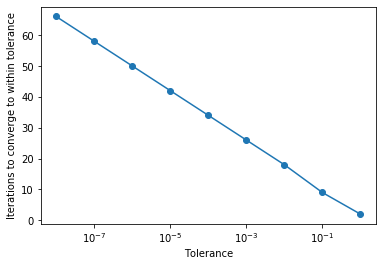

In [17]:
optimal_policy = policy_iters[-1]
mdp = build_hallway_mdp()

values, iters = iterative_value_estimation(mdp, optimal_policy)
print('Original Optimal Policy value:')
print(values.round(4))

print('Number of Iterations to Converge to a precision of 10−5:')
print(iters)

values, iters = iterative_value_estimation(mdp_stochastic, optimal_policy)
print('Stochastic MDP Optimal Policy value:')
print(values.round(4))

print('Number of Iterations to Converge to a precision of 10−5:')
print(iters)

tols = np.logspace(0,-8,9)
iters = [iterative_value_estimation(mdp_stochastic, always_left, tol=tol)[1] for tol in tols]
plt.plot(tols, iters, marker='o')
plt.xscale('log')
plt.xlabel("Tolerance")
plt.ylabel("Iterations to converge to within tolerance")
plt.show()

<div style="border: 3px solid #800080; padding: 10px"> 

***Optimal Policy for Stochastic MDP:***

Starting State | Action
---------------|-------
0              | Go Right
1              | Go Right
2              | Go Right
3              | Go Right
4              | Go Right

<br>

***Expected sum of future rewards for "Optimal Policy" under Stochastic MDP:***

State|Reward-Stochastic MDP|Reward-MDP
-|-|-
0|6.74|9.92
1|10.71|14.56
2|16.61|20.75
3|24.89|29.00
4|36.51|40.00

<br>

***Observations:***
* Optimal Policy under Stochastic MDP is same as non-stochastic MDP
* Expected Future Rewards are lower in case of Stochastic MDP due to non-zero probabilty of non-optimal outcomes
* For "Always Left" policy the expected future rewards will be higher under stochastic MDP due to non-zero probability of better than the worst outcome

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> End of Homework